# Plotting even distributions of data in the Inverse Pole Figure

@ Mallory Wittwer (mallory.wittwer@gmail.com)

When a dataset contains both crystallographic texture, which translates to *spatial density* variations in the IPF plot, and some systematic property variation across the IPF space, such as misorientation, for example, plotting it can be challenging. A correct and simple way is to use a scatter plot, with the points colored according to the value of interest. However, this can be confusing when the number of points to plot is large (>10'000) because most data points overlap and there is no clear guide for the eye to recognize systematic trends.

Here, instead, we first **subdivide the IPF space into equivalent regions**, meaning that the maximum misorientation between any two points within a single region is about the same for all regions. This cannot be achieved by simply subdividing the IPF plot with an even grid because the stereographic projection does not conservative distances. To provide an even segmentation of the IPF space, I first computed a [Fibonacci sphere](https://www.redblobgames.com/x/1842-delaunay-voronoi-sphere/) of a pre-defined order and subdivided it using a [Voronoi decomposition](https://en.wikipedia.org/wiki/Voronoi_diagram). Then, I projected the Voronoi tesselation into the IPF space using the stereographic projection. I computed a group value for each tile based on the average of the data points within it (and color-coded this value). Pretty fun!

Do let me know if anything's unclear about the code!

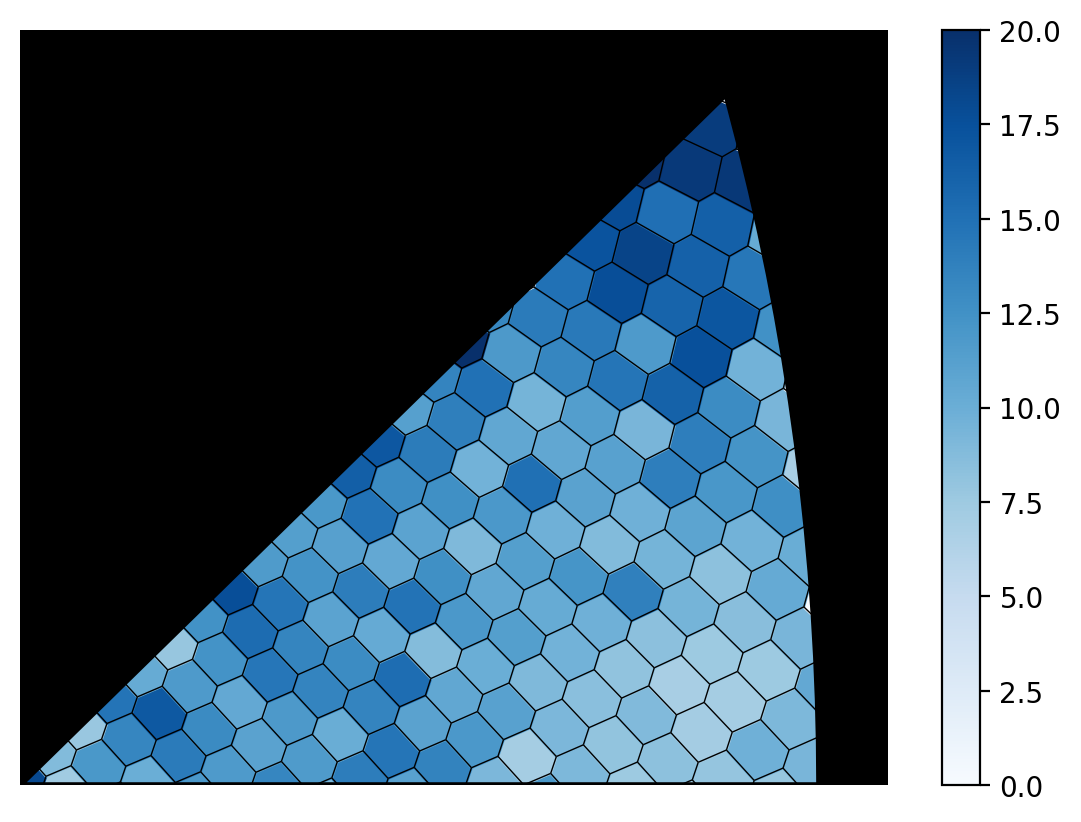

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.colors as clrs
from sklearn.metrics import pairwise_distances
import tensorflow as tf

def voronoi_IPF(eulers, z_values, n_fib_tiles=3000, line_width=0, direction='z', vmin=None, vmax=None):
    '''
    A plotting function to visualize distributions of data in the Inverse Pole Figure (IPF) space; we are looking at a sparse 
    cloud of points in orientation space (for example 1 point per grain) each with an associated value of interest (for example,
    the disorientaiton angle). The plot shows if there is a trend in the distribution of values of interest in orientation space.
    
    eulers: an array of shape (:,3) representing a set of ZYZ intrinsic Euler angles.
    z_values: an array of shape (:,1) representing the value of interest associated with each set of Euler angle.
    n_fib_tiles: number of Voronoi tiles to compute (the resolution of the "bins" for averaging). A good default is to set the 
                 number of tiles so that there are at least 10 data points in the least populated tile.
    line_width: width of the Voronoi tile lines.
    direction: IPF plotting direction - 'x', 'y' or 'z'.
    '''
    def eulers_to_rot_mat(eulers):
        i1  = eulers[:,0]
        i2  = eulers[:,1]
        i3  = eulers[:,2]       
        i1c = tf.cos(i1)
        i1s = tf.sin(i1)
        i2c = tf.cos(i2)
        i2s = tf.sin(i2)
        i3c = tf.cos(i3)
        i3s = tf.sin(i3)
        x00 = i1c*i2c*i3c-i1s*i3s
        x01 = -i3c*i1s-i1c*i2c*i3s
        x02 = i1c*i2s
        x10 = i1c*i3s+i2c*i3c*i1s
        x11 = i1c*i3c-i2c*i1s*i3s
        x12 = i1s*i2s
        x20 = -i3c*i2s
        x21 = i2s*i3s
        x22 = i2c
        c0 = tf.stack((x00,x01,x02), axis=1)
        c1 = tf.stack((x10,x11,x12), axis=1)
        c2 = tf.stack((x20,x21,x22), axis=1)
        rot_mat = tf.stack((c0,c1,c2), axis=1)
        return rot_mat

    @tf.function
    def visualize(eulers, rx, ry, reshape=True):
        rot_mat = eulers_to_rot_mat(eulers)
        rot_mat_inv = tf.linalg.inv(rot_mat)
        output = tf.concat((_symmetrize(rot_mat_inv[:,:,0]),
                            _symmetrize(rot_mat_inv[:,:,1]),
                            _symmetrize(rot_mat_inv[:,:,2])), axis=1)
        xmap = _colorize(output[:,0:3])#.numpy()
        ymap = _colorize(output[:,3:6])#.numpy()
        zmap = _colorize(output[:,6:9])#.numpy()
        if reshape:
            xmap = xmap.reshape((rx,ry,3))
            ymap = ymap.reshape((rx,ry,3))
            zmap = zmap.reshape((rx,ry,3))
        return xmap, ymap, zmap

    def _compute_vectors(eulers):
        rot_mat = eulers_to_rot_mat(eulers)
        rot_mat_inv = tf.linalg.inv(rot_mat)
        xv = _symmetrize(rot_mat_inv[:,:,0])
        yv = _symmetrize(rot_mat_inv[:,:,1])
        zv = _symmetrize(rot_mat_inv[:,:,2])
        return xv, yv, zv

    def _vector_project(zvector):
        rZ = np.empty(zvector.shape[0])
        theZ = np.empty(zvector.shape[0])
        for k, vect in enumerate(zvector):
            theZ[k] = np.arctan2(vect[1], vect[0])
            rZ[k]   = np.sin(np.arccos(vect[2]))/(1+np.arccos(np.cos(vect[2])))
        xes_preds = rZ*np.cos(theZ)
        yes_preds = rZ*np.sin(theZ)
        return xes_preds, yes_preds

    def _symmetrize(indeces): 
        indeces = tf.abs(indeces)
        norms = tf.square(indeces[:,0])+tf.square(indeces[:,1])+tf.square(indeces[:,2]) # already all 1?
        norms = tf.expand_dims(norms, 1) 
        indeces = indeces/norms
        indeces = tf.sort(indeces, axis=1, direction='ASCENDING')
        return indeces

    def _colorize(indeces):
        a = tf.abs(tf.subtract(indeces[:,2], indeces[:,1]))
        b = tf.abs(tf.subtract(indeces[:,1], indeces[:,0]))
        c = indeces[:,0]
        rgb = tf.concat((tf.expand_dims(a, -1), 
                         tf.expand_dims(b, -1), 
                         tf.expand_dims(c, -1)), axis=1)
        # Normalization
        maxes = tf.reduce_max(rgb, axis=1)
        a = a/maxes
        b = b/maxes
        c = c/maxes
        rgb    = tf.concat((tf.expand_dims(a, -1), 
                            tf.expand_dims(b, -1), 
                            tf.expand_dims(c, -1)), axis=1)
        return rgb
    
    def cart2spher(x, y, z):
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z/r)
        phi = np.arctan2(y,x) + np.radians(180)
        return (r, theta, phi)
    
    def get_region_values(vor, xyc, zees):
        vor_points = np.array(vor.points)
        regvals = np.zeros((len(vor_points)))
        n_vals_cell = np.zeros((len(vor_points)))
        knn_idx = np.argmin(pairwise_distances(
            X=xyc, Y=vor_points, metric='euclidean'), axis=1)
        for ind, zval in zip(knn_idx, zees):
            n_vals_cell[ind] += 1
            regvals[ind] += (zval - regvals[ind]) / n_vals_cell[ind]
        return regvals
    
    eulers_ref = np.radians(np.array([
        [0, 0, 0], # 100
        [0, 45, 0], # 110
        [0, 54.74, 45], # 111

    ]))
    
    xvr, yvr, zvr = _compute_vectors(eulers_ref)
    yes_ref, xes_ref = _vector_project(zvr)
    
    xv, yv, zv = _compute_vectors(eulers)
    if direction=='z':
        yes, xes = _vector_project(zv)
    elif direction=='y':
        yes, xes = _vector_project(yv)
    elif direction=='x':
        yes, xes = _vector_project(xv)

    xy_coords = np.vstack((xes, yes)).T
    
    points = []
    spherical_points = []
    phi = math.pi * (3. - math.sqrt(5.))
    for i in range(n_fib_tiles*16):
        theta = phi * i        
        y = 1 - (i / float(n_fib_tiles*16 - 1)) * 2 
        radius = math.sqrt(1 - y * y)
        x = math.cos(theta) * radius
        z = math.sin(theta) * radius    
        spherical_points.append(cart2spher(x, y, z))
        X = x / (1-z)
        Y = y / (1-z)
        points.append((X, Y))
    spherical_points = np.array(spherical_points)
    points = np.array(points)
    filt = (spherical_points[:,1] >= np.radians(90))
    spherical_points = spherical_points[filt]
    points = points[filt]
    points = -points

    R = np.sqrt(points[:,0]**2 + points[:,1]**2)
    filt = (R <= 0.8)
    points = points[filt]

    vor = Voronoi(points)
    
    fig, ax = plt.subplots(figsize=(7,5), dpi=200)
    
    voronoi_plot_2d(vor, show_points=False, show_vertices=False, 
                    line_width=line_width, line_colors='black', ax=ax)
    
    region_values = get_region_values(vor, xy_coords, z_values)
    mapper = plt.cm.ScalarMappable(
        norm=clrs.Normalize(vmin=np.min(z_values) if vmin is None else vmin, 
                            vmax=np.max(z_values) if vmax is None else vmax,
                            clip=True),
        cmap=plt.cm.Blues)
    for r in range(len(vor.point_region)):
        region = vor.regions[vor.point_region[r]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            plt.fill(*zip(*polygon), color=mapper.to_rgba(region_values[r]))
    plt.colorbar(mapper)
    
    ax.set_ylim(0, 0.40)
    ax.set_xlim(0, 0.45)
    ax.axis('off')
    
    theta_array = np.radians(np.linspace(0,45,50))
    x_circle_ref = np.sqrt(2) * np.cos(theta_array) - 1.0
    y_circle_ref = np.sqrt(2) * np.sin(theta_array)
    
    ax.plot(x_circle_ref, y_circle_ref, color='black', linewidth=2, zorder=10)
       
    ax.plot([xes_ref[2], xes_ref[0], xes_ref[1]], 
            [yes_ref[2], yes_ref[0], yes_ref[1]], 
            color='black', linewidth=2, zorder=10)

    plt.fill([0.0,0.0,0.4], [0.0,0.4,0.4], 'black')
    
    xcr = x_circle_ref.copy()
    xcr = np.append(xcr, [0.45, 0.45])
    ycr = y_circle_ref.copy()
    ycr = np.append(ycr, [0.4,0.0])
    plt.fill(xcr, ycr, 'black')
    
    plt.show()

# Demo:
eulers_demo = np.load('eulers_demo.npy') # Example of Euler angles array
values_demo = np.load('values_demo.npy') # Example of disorientaiton angles
      
voronoi_IPF(eulers=eulers_demo, z_values=values_demo, n_fib_tiles=400, line_width=0.5, direction='z', vmin=0, vmax=20)